In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import rcParams
import time
from copy import copy

from sim_handling import Simulation,loadSim
from diffusionstuff7 import f0d,f1d,f2d, getsigmastep_2d
from matplotlib.animation import PillowWriter

C:\Users\Max-PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\llvmlite\llvmpy\__init__.py:3: UserWarning: The module `llvmlite.llvmpy` is deprecated and will be removed in the future.
  warnings.warn(
C:\Users\Max-PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\llvmlite\llvmpy\core.py:8: UserWarning: The module `llvmlite.llvmpy.core` is deprecated and will be removed in the future. Equivalent functionality is provided by `llvmlite.ir`.
  warnings.warn(
C:\Users\Max-PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\llvmlite\llvmpy\passes.py:17: UserWarning: The module `llvmlite.llvmpy.passes` is deprecated and will be removed in the future. If you are using this code, it should be inlined into your own project.
  warnings.warn(


Goal is to reproduce steady state growth. Trying to use older code that has the 2nd partial differential equation in it to do this.

In [2]:
%matplotlib widget

In [6]:
 #set up and run and plot a new simulation
test_1d_asym = Simulation(f1d, (500,), method='RK45', rtol=1e-12)
#test_1d_asym = Simulation(f1d, (500,), method='LSODA')

test_1d_asym.discretization_halt = False

#try a noisy simulation
test_1d_asym.noisy_init = False

#test_1d_asym.float_params['DoverdeltaX2'] *= 2 # raised to lower parameter product value
test_1d_asym.layermax = 300
#test_2d_asym.sigmastepmax= -0.01 #ablation
test_1d_asym.sigmastepmax = 0.195 #growth - lowered to lower parameter product value
test_1d_asym.sigmastepmax = 0.20 
test_1d_asym.center_reduction = 0.25
#test_2d_asym.center_reduction = 0.003 # lowered to lower parameter product value


breaking because reached max number of layers grown


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


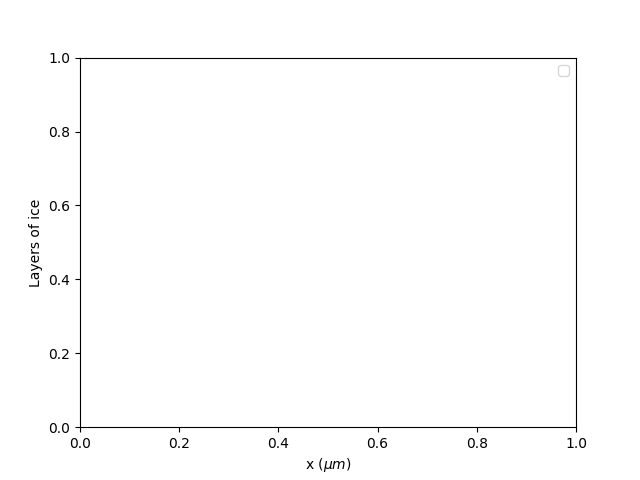

NameError: free variable 'Ntot' referenced before assignment in enclosing scope

In [7]:
#animate the simulation (runs if needed)
#test_2d_asym.run(halve_time_res=True) #only saves half the time steps since it is a huge simulation

anim = test_1d_asym.animate(ret=True, focus_on_growth=True, speed=100) # proportionalSpeed=True)

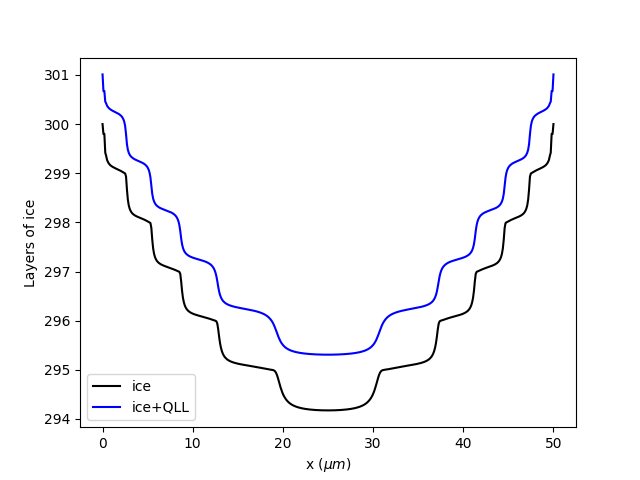

In [5]:
#plot the simulation at the end
test_1d_asym.plot(completion=1, ice=True, tot=True, figurename='ending surface')

In [ ]:
plt.close('ending surface')

(47551, 500)


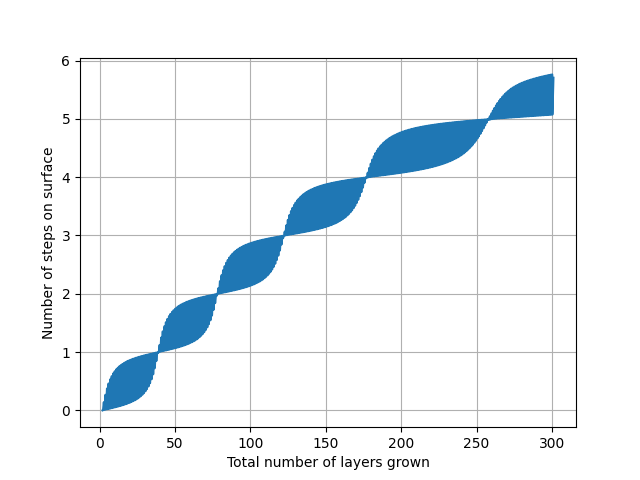

In [8]:
#graph number of steps over time
Ntot = test_1d_asym.getNtot()
#Ntot = cycle_sim.getNtot()
print(Ntot.shape)

maxes = np.array([np.max(n) for n in Ntot[:]])
mins = np.array([np.min(n) for n in Ntot[:]])

#print(maxes,mins)
plt.figure('Number of steps over time')
ax = plt.subplot(111)

ax.set_ylabel('Number of steps on surface')

if test_1d_asym.sigmastepmax < 0: #ablation case
    ax.set_xlabel('Total number of layers ablated')
    ax.plot( Ntot[::-1,0]+test_1d_asym.layermax,maxes-mins) #flipping to show ablation progress from left to right, adding layermax to show # layers ablated instead of negative # layers grown
else: #growth case   
    ax.set_xlabel('Total number of layers grown')
    ax.plot( Ntot[:,0],maxes-mins)

plt.grid()

In [ ]:
plt.close('Number of steps over time')

In [ ]:
#calculating Nss vs parameter thingy

# N_ss = # number of steps to steady state 
from pint import UnitRegistry; AssignQuantity = UnitRegistry().Quantity


#slope and intercept of linear fit of figure11 x to N_ss
#for sinusoidal growth
M = 0.0027 # bilayers / micron ????
M = 2.7 # what it actually looks like on the plot in the paper
B= 2.9 #bilayers
#for parabolic growth
#M = 0.0025
#B = 1.6

def Nss_fig11(M,B,x):
    return M*x + B

def figure11(L,D,c_r,nu_kin,sigma):
    """
    L: length of domain, microns
    D: diffusion coefficient, microns^2 / microsecond
    c_r: center reduction, fraction
    nu_kin: growth rate, microns / second
    sigma: supersaturation at corner, fraction
    """
    beta = 0.65
    return nu_kin*L**2*sigma*(c_r)**beta / D

#Lx,Ly = test_1d_asym.shape # num points
Lx, = test_1d_asym.shape # num points
Lx_mu = AssignQuantity(25, 'microns')
c_r = test_1d_asym.center_reduction/100
sigma = test_1d_asym.sigmastepmax
beta = 0.65 #value from paper 
nu_kin = AssignQuantity(test_1d_asym._extra_vars.get('nu_kin'), 'micron/second') #microns /second
D = AssignQuantity(test_1d_asym._extra_vars.get('D'),'micron^2 / microsecond')

#print('Lx,Ly',Lx,Ly)
print('Lx',Lx)
print('sigma',sigma)
print('beta',beta)
print('nu_kin',nu_kin)
print('D',D)
print('c_r',c_r)

x = figure11(Lx_mu,D,c_r,nu_kin,sigma)
x.ito('microns')
print('x with min values from paper: ',x)
print('predicted number of steps at steady state: ', Nss_fig11(M,B,x.magnitude))


#min values from paper
Lx_mu = AssignQuantity(17.5,'microns')
D = AssignQuantity(0.75E-4,'microns^2 / microsecond')
c_r = 0.15/100
nu_kin = AssignQuantity(20,'microns/second')
sigma = 0.20

#print('Lx,Ly',Lx,Ly)
print('Lx',Lx)
print('sigma',sigma)
print('beta',beta)
print('nu_kin',nu_kin)
print('D',D)
print('c_r',c_r)

x = figure11(Lx_mu,D,c_r,nu_kin,sigma)
x.ito('microns')
print('x with min values from paper: ',x)
print('predicted number of steps at steady state: ', Nss_fig11(M,B,x.magnitude))


#max values from paper
Lx_mu = AssignQuantity(42.5,'microns')
D = AssignQuantity(6E-4,'microns^2 / microsecond')
c_r = 0.7/100
nu_kin = AssignQuantity(140,'microns/second')
sigma = 0.50

#print('Lx,Ly',Lx,Ly)
print('Lx',Lx)
print('sigma',sigma)
print('beta',beta)
print('nu_kin',nu_kin)
print('D',D)
print('c_r',c_r)

x = figure11(Lx_mu,D,c_r,nu_kin,sigma)
x.ito('microns')
print('x with max values from paper: ',x)
print('predicted number of steps at steady state: ', Nss_fig11(M,B,x.magnitude))

In [ ]:
#calculating parameterization produce (fig 11) for simulation
Lx,Ly = test_1d_asym.shape # num points
sigma = test_1d_asym.sigmastepmax
beta = 0.65 #value from paper 
nu_kin = AssignQuantity(test_1d_asym._extra_vars.get('nu_kin'), 'micron/second') #microns /second
D = AssignQuantity(test_1d_asym._extra_vars.get('D'),'micron^2 / microsecond')
c_r = test_1d_asym.center_reduction

#min values from paper
Lx_mu = AssignQuantity(25,'microns')
Ly_mu = Ly/Lx * Lx_mu

x = figure11(Lx_mu,D,c_r,nu_kin,sigma)
x.ito('microns')
print(x)

In [ ]:
#plot surface at middle and end of simulation
plot = test_1d_asym.plot(ice=True,completion=0.2)


In [ ]:
plt.close()

In [ ]:
#continuation of previous simulation
#start a second simulation starting with the ending surface of the first 
# as the initial surface

#create 1d sim and graph number of steps over time
cycle_sim =  Simulation(f2d, (test_1d_asym.shape[0],test_1d_asym.shape[1]), method=test_1d_asym.method, rtol=test_1d_asym.rtol)

#keep general params same
cycle_sim.layermax = 1000 #st_2d_asym.layermax * 1.5 #make sure it reaches steady state
cycle_sim.float_params['DoverdeltaX2'] = test_1d_asym.float_params['DoverdeltaX2'] 
cycle_sim.sigma0 = test_1d_asym.sigma0
cycle_sim.center_reduction = test_1d_asym.center_reduction
cycle_sim.deltaT = test_1d_asym.deltaT #increase time step to decrease number of steps saved?
cycle_sim.noisy_init = test_1d_asym.noisy_init

#set up initial surface
cycle_sim.nonstd_init = True
ntots = test_1d_asym.getNtot()
cycle_sim.startingNtot = ntots[len(ntots)//2] #start with the middle of the last simulation, before discretzation error

#set to ablation run
cycle_sim.sigmastepmax = 0.20 


In [ ]:
#animate ablation of growth ending surface
anim = cycle_sim.animate(ret=True, focus_on_growth=True, proportionalSpeed=False)

In [ ]:
#graph number of steps over time for second simulation
Ntot = cycle_sim.getNtot()
#Ntot = cycle_sim.getNtot()

maxes = np.array([np.max(n) for n in Ntot[:]])
mins = np.array([np.min(n) for n in Ntot[:]])

#print(maxes,mins)
plt.figure()
ax = plt.subplot(111)

ax.set_ylabel('Number of steps on surface')

if cycle_sim.sigmastepmax < 0: #ablation case
    ax.set_xlabel('Total number of layers ablated')
    ax.plot( Ntot[::-1,0,0]+cycle_sim.layermax,maxes-mins) #flipping to show ablation progress from left to right, adding layermax to show # layers ablated instead of negative # layers grown
else: #growth case   
    ax.set_xlabel('Total number of layers grown')
    ax.plot( Ntot[:,0,0],maxes-mins)

plt.grid()